In [40]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTENC
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import time
import warnings
warnings.filterwarnings("ignore")

In [41]:
# Load in data, create train, validation split, get categorical and ambiguous features, scale data, use SMOTENC to upsample data
train = pd.read_csv('train.csv')
drop_features = ['Over18', 'EmployeeCount', 'StandardHours', 'EmployeeID']
good_features = [c for c in train.columns if c not in drop_features]
ambiguous_features = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'Shift', 'WorkLifeBalance']

numerical_features = list(set(train[good_features].select_dtypes(include=np.number).columns) - set(ambiguous_features))
categorical_features = [f for f in train.columns if f not in numerical_features and f not in drop_features]
catx_features = [f for f in categorical_features if f != 'Attrition']

train_dummies = pd.get_dummies(train[good_features], columns=categorical_features, drop_first=True)
# amb_train_dummies = pd.get_dummies(train_dummies, columns=ambiguous_features, drop_first=True)

train_y = train_dummies.Attrition_Yes
train_x = train_dummies.loc[:, train_dummies.columns != 'Attrition_Yes']
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.2)

catxt_features = [f for f in train_x.columns if '_' in f]
numxt_features = [f for f in train_x if f not in catxt_features]

test_x_original = pd.read_csv('test.csv')
test_features = [c for c in good_features if c != 'Attrition']
test_cat = [c for c in categorical_features if c != 'Attrition']
test_x = pd.get_dummies(test_x_original[test_features], columns=test_cat, drop_first=True)
test_x_scaled = StandardScaler().fit_transform(test_x)

x_cat = [train_x.columns.get_loc(c) for c in train_x.columns if '_' in c]

train_x_scaled = StandardScaler().fit_transform(x_train)
val_scaled = StandardScaler().fit_transform(x_val)

train_xf_scaled = StandardScaler().fit_transform(train_x)

smotef = SMOTENC(categorical_features=x_cat, k_neighbors=7)
xf_sr_train, yf_sr_train = smotef.fit_resample(train_xf_scaled, train_y)

In [42]:
# Conduct 5-fold cross validation on C parameter, store result
Cs = [0.1, 1, 2, 3, 5, 10, 100, 1000, 10000, 100000]
kfold = KFold(n_splits=5)
k_train_scores = []
k_val_scores = []
for c in Cs:
    train_scores = []
    val_scores = []
    for tr_idx, val_idx in kfold.split(train_x):
        xt_scaled= StandardScaler().fit_transform(train_x.iloc[tr_idx])
        xv_scaled = StandardScaler().fit_transform(train_x.iloc[val_idx])
        xt_up_scaled, yt_up = SMOTENC(categorical_features=x_cat, k_neighbors=50).fit_resample(xt_scaled, train_y.iloc[tr_idx])
        log_reg = LogisticRegression(C=c, class_weight={0:0.5, 1:0.5}).fit(xt_up_scaled, yt_up)
        # print(f1_score(log_reg.predict(xv_scaled), train_y[val_idx]))
        train_scores.append(f1_score(log_reg.predict(xt_up_scaled), yt_up))
        val_scores.append(f1_score(log_reg.predict(xv_scaled), train_y.iloc[val_idx]))
    k_train_scores.append(np.mean(train_scores))
    k_val_scores.append(np.mean(val_scores))

Text(0.5, 1.0, 'Average 5-Fold Validation Score by C Value, SMOTE k_neighbors = 50')

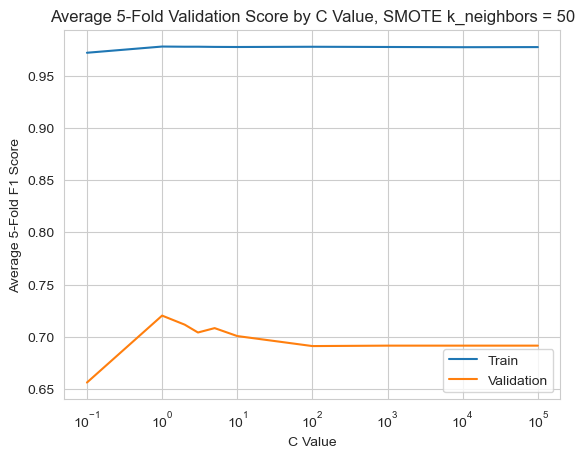

In [43]:
# Plot cross validation train and validation f1 scores across tested C values
plt.plot(Cs,k_train_scores, label='Train')
plt.plot(Cs,k_val_scores, label='Validation')
plt.legend()
plt.xscale('log')
plt.xlabel('C Value')
plt.ylabel('Average 5-Fold F1 Score')
plt.title('Average 5-Fold Validation Score by C Value, SMOTE k_neighbors = 50')
# plt.savefig('Graphs/LogRegCVk50.png', bbox_inches='tight')

0.03200888633728027


Text(0.5, 0, 'Coefficient Value')

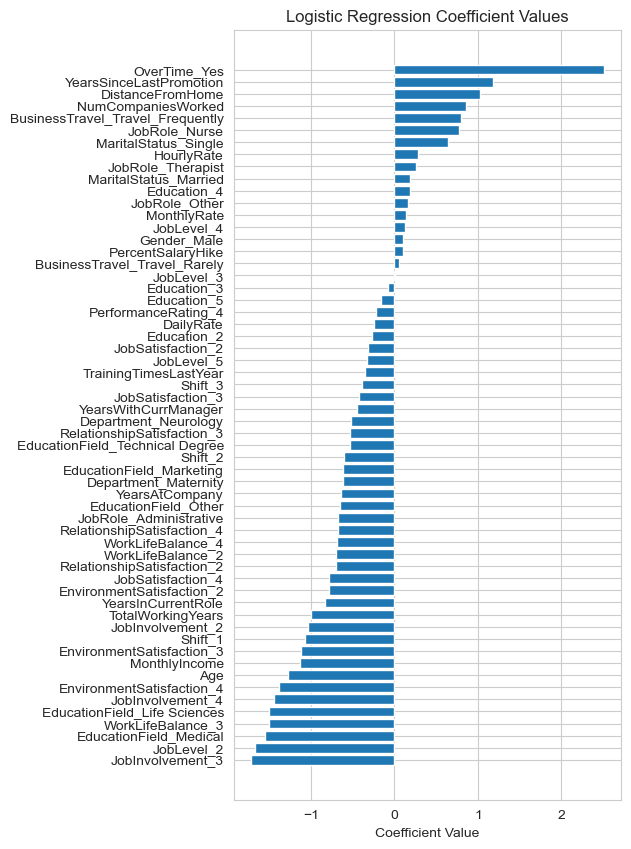

In [44]:
# Make bar chart of coefficient values
xt_scaled= StandardScaler().fit_transform(train_x)
xt_up_scaled, yt_up = SMOTENC(categorical_features=x_cat, k_neighbors=15).fit_resample(xt_scaled, train_y)
cur = time.time()
lg_reg = LogisticRegression(C=3).fit(xt_up_scaled, yt_up)
print(time.time() - cur)
plt.figure(figsize=(5,10))
f_i = list(zip(train_x.columns, lg_reg.coef_[0].tolist()))
f_i.sort(key=lambda x: x[1], reverse=False)
s_c = [x[0] for x in f_i]
s_f = [x[1] for x in f_i]
plt.barh(s_c, s_f)
plt.title('Logistic Regression Coefficient Values')
plt.xlabel('Coefficient Value')
# plt.savefig('Graphs/LGCoef.png', bbox_inches='tight')

Train f1:  0.9786552828175026
Val f1:  0.6885245901639345


Text(52.722222222222214, 0.5, 'True Attrition Value')

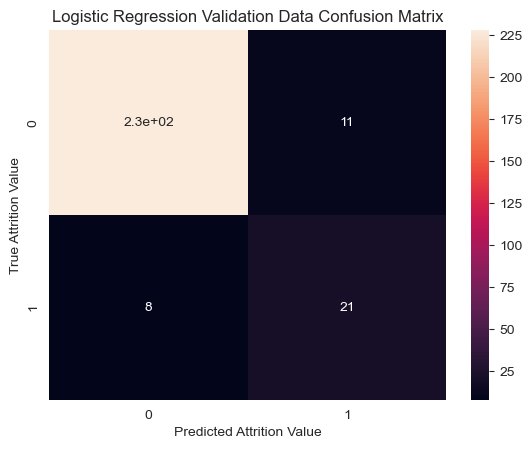

In [45]:
# Generate confusion matrix on validation data
xt_scaled = StandardScaler().fit_transform(x_train)
xv_scaled = StandardScaler().fit_transform(x_val)
xt_up_scaled, yt_up = SMOTENC(categorical_features=x_cat, k_neighbors=15).fit_resample(xt_scaled, y_train)
lr_cv = LogisticRegression(C=10, class_weight={0:0.5, 1:0.5}).fit(xt_up_scaled, yt_up)
print('Train f1: ', f1_score(lr_cv.predict(xt_up_scaled), yt_up))
print('Val f1: ', f1_score(lr_cv.predict(xv_scaled), y_val))
sns.heatmap(confusion_matrix(y_pred=lr_cv.predict(xv_scaled), y_true=y_val), annot=True)
plt.title('Logistic Regression Validation Data Confusion Matrix')
plt.xlabel('Predicted Attrition Value')
plt.ylabel('True Attrition Value')
# plt.savefig('Graphs/LRCM.png', bbox_inches='tight')

In [46]:
# Generate predictions from logistic regression model
lr = LogisticRegression(C=10000, class_weight={0:0.5, 1:0.5}).fit(xf_sr_train, yf_sr_train)
submission14 = pd.DataFrame(lr.predict(test_x_scaled)).rename(columns={0: 'Predicted'})
# submission14.index.rename('Id', inplace=True)
# submission14.to_csv('submission15.csv')